# Evaluation trained discrete model of a Lagrangian density

## Loading and initialisation of the trained model

In [1]:
# load packages
using JSON
using Plots
using FFTW

# load tools
include("7ptStencilFun.jl")
include("SpectralTools.jl")
include("FindTravellingWave.jl")

# load model
run_data=JSON.parsefile("2023-01-31_08-53-14run_data.json");

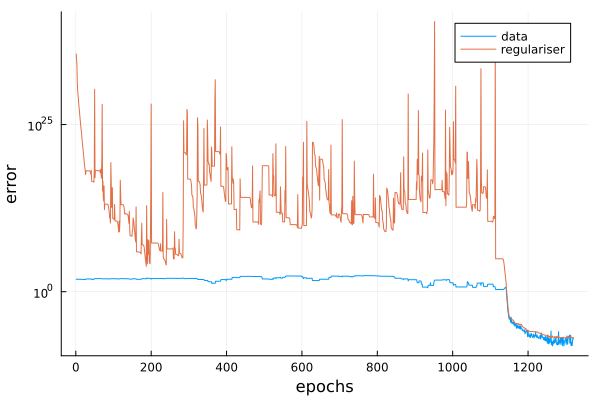

In [2]:
# plot training behaviour
plot(transpose(hcat(run_data["training_losses"]...)), yaxis=:log, xlabel="epochs", ylabel="error", labels=["data" "regulariser"])

In [3]:
println("final loss data "*string(run_data["training_losses"][end][1])*", final loss regulariser "*string(run_data["training_losses"][end][2])*", epochs "*string(length(run_data["training_losses"])))

final loss data 8.563788651747649e-8, final loss regulariser 1.3912982448402586e-7, epochs 1320


In [4]:
# form 3-layer neural network for discrete Lagrangian density
function LdArchitecture(paramVec,x0)
    
    A1 = reshape(paramVec[1:10*3],(10,3))
    A2 = reshape(paramVec[10*3+1: 10*3+10*10],(10,10))
    A3 = reshape(paramVec[10*3+10*10+1:10*3+10*10+1*10],(1,10))
    
    b1 = paramVec[10*3+10*10+1*10+1:10*3+10*10+1*10+10]
    b2 = paramVec[10*3+10*10+1*10+10+1:end]

    x1 = tanh.(A1*x0 + b1)
    x2 = tanh.(A2*x1 + b2)
    x3 = A3*x2
    
    return x3[1]    
end


# define learned functions from learned model
paramVec = Float64.(run_data["learned_parameters"]);
learned_Ld(z) = LdArchitecture(paramVec,z)
Learned_Ld(u,udown,uleft) = LdArchitecture(paramVec,[u,udown,uleft])
Learned_L(u,ut,ux) = learned_Ld([u,u-dt*ut,u-dx*ux])
function Learned_L(uJet1);    u,ut,ux = uJet1;    return Learned_L(u,ut,ux); end

# define reference Lagrangian for tests
Potential_ref(u) = 1/2  * u^2
Lagrangian_ref(u,ut,ux) = 1/2*ut^2-1/2*ux^2-Potential_ref(u)
Lagrangian_ref_d(u,udown,uleft) = Lagrangian_ref(u,(u-udown)/dt,(u-uleft)/dx)
function Lagrangian_ref(uJet1);    u,ut,ux = uJet1;    return Lagrangian_ref(u,ut,ux); end
function Lagrangian_ref_d(uCollect);    u,udown,uleft = uCollect;    return Lagrangian_ref_d(u,udown,uleft); end

Lagrangian_ref_d (generic function with 2 methods)

In [5]:
# set parameters of space-time domain
l = 1. # length of spatial domain including (periodic) boundary
T = .5 # final time

# discretisation parameters
M = length(run_data["training_data"][1]) # spatial grid points 
N = length(run_data["training_data"][1][1])-1 # time steps

dx = l/M # periodic boundary conditions
dt = T/N

# initial values (periodic)
XMesh   = 0:dx:(M-1)*dx
XMeshbd = 0:dx:M*dx # repeat boundary
TMesh = 0:dt:N*dt

0.0:0.025:0.5

In [6]:
converter = x-> hcat(x...)
training_data=converter.(run_data["training_data"]);

In [7]:
# function for plotting
function plotU(U)
    n = size(U)[1]-1
    TMesh = 0:dt:n*dt
    UPlot = [U U[:,1]] # add repeated boundary for plotting
    return plot(XMeshbd,TMesh,UPlot,st=:surface,xlabel="x",ylabel="t",legend=:none)
end

function contourU(U)
    n = size(U)[1]-1
    TMesh = 0:dt:n*dt
    UPlot = [U U[:,1]] # add repeated boundary for plotting
    return contour(XMeshbd,TMesh,UPlot,xlabel="x",ylabel="t",legend=:none)
end

contourU (generic function with 1 method)

## Model evaluation
### continuation of solutions seen during training

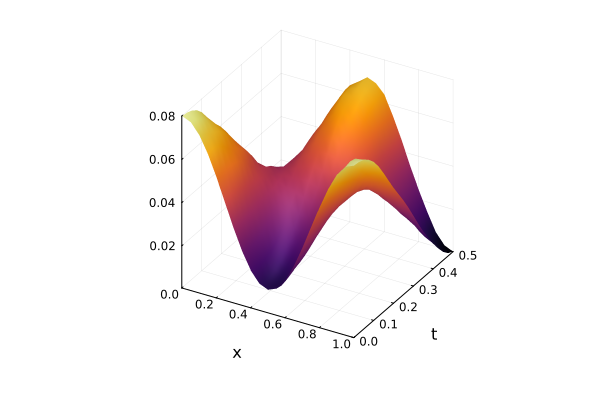

In [8]:
# plotting
U_ref=training_data[3]
plotU(U_ref)

In [9]:
u0 = U_ref[1,:]
u1 = U_ref[2,:]
U=PDEContinue(Learned_Ld, u0, u1; time_steps=N);

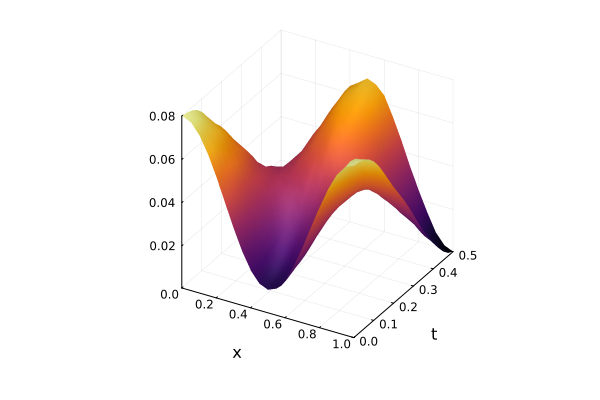

In [10]:
plotU(U)

In [11]:
# error
maximum(abs.(U_ref-U))

0.0006040500955503889

### unseen initial values

In [12]:
u0 = sin.(2*pi/l*XMesh)
u1 = sin.(2*pi/l*XMesh)
U_unseen_ref=PDEContinue(Lagrangian_ref_d, u0, u1; time_steps = N);

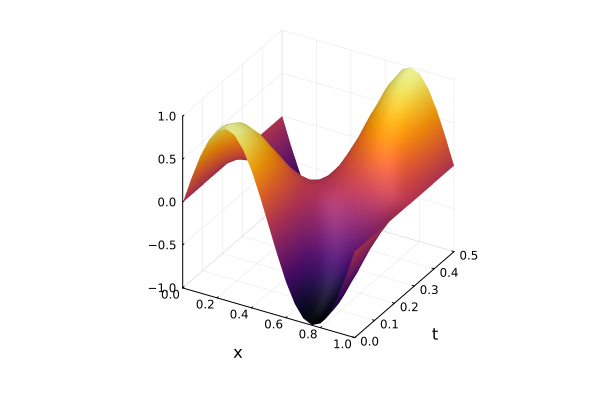

In [13]:
plotU(U_unseen_ref)

In [14]:
U_unseen = PDEContinue(Learned_Ld, u0, u1; time_steps=N);

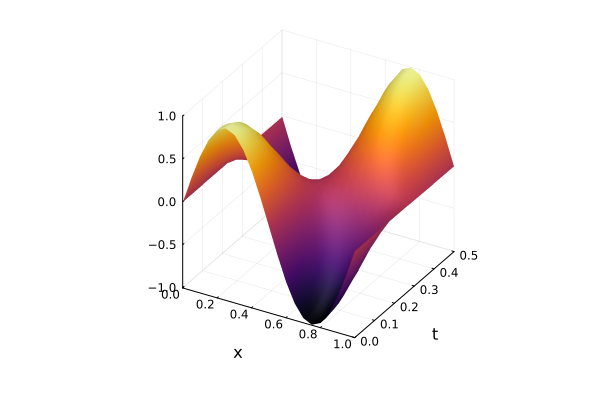

In [15]:
plotU(U_unseen)

In [16]:
# error
maximum(abs.(U_unseen-U_unseen_ref))

0.011448138043014951

### prediction outside the space-time domain seen during training

In [17]:
U_unseen_continue = PDEContinue(Learned_Ld, u0, u1; time_steps=5*N);
U_unseen_continue_ref = PDEContinue(Lagrangian_ref_d, u0, u1; time_steps=5*N);

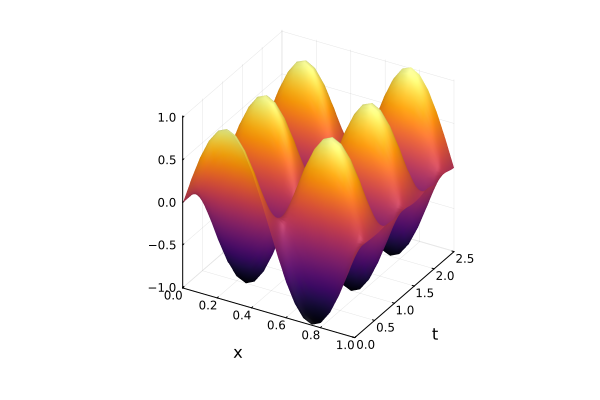

In [18]:
plotU(U_unseen_continue)

In [19]:
# error
maximum(abs.(U_unseen_continue-U_unseen_continue_ref))

0.04291928261087566

### initialisation with init. condition u0 and velocity profile v0 rather u0,u1

In [20]:
u0dot = -10*u0;
U_unseen_vel=PDESolve(Learned_L, u0, u0dot; interval_length = l, time_steps = N, t_final = T)
U_unseen_ref_vel=PDESolve(Lagrangian_ref, u0, u0dot; interval_length = l, time_steps = N, t_final = T);

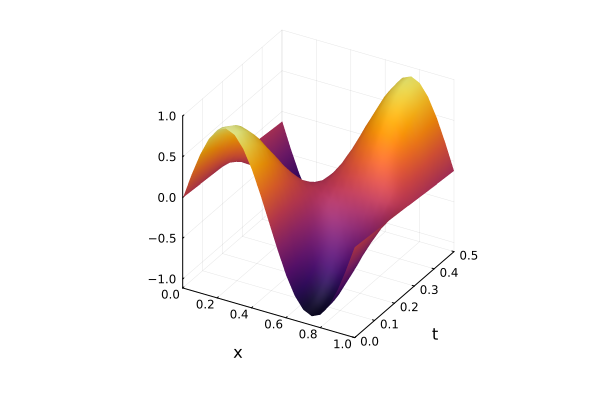

In [21]:
plotU(U_unseen_vel)

In [22]:
# error
maximum(abs.(U_unseen_vel-U_unseen_ref_vel))

0.1200838857356863

## Travelling Waves

### Are traveling waves of Ld_ref also travelling waves of the learned model Ld_ML?

#### TW of the discrete travelling wave equation (reference)

consistency with DEL: 2.2168933355715126e-12

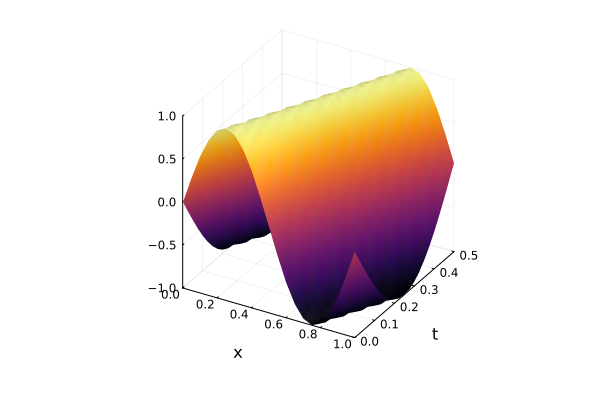

In [23]:
wave_no = 1
kappa = 2*pi*wave_no/l

lattice_eq_rhs = 1+ dt^2/dx^2*(cos(kappa*dx)-1) - dt^2/2

if abs(lattice_eq_rhs)>1
    print("The discretised PDE does not admit real valued travelling wave with this wave number for this potential/dx/dt. Discriminant ")
    print(lattice_eq_rhs)
end

c_tw_discrete=acos(lattice_eq_rhs)/(kappa*dt)

amplitude_discrete = [1.,0.]
tw_discrete(t,x) = amplitude_discrete[1]*sin(kappa*(x-c_tw_discrete*t))+amplitude_discrete[2]*cos(kappa*(x-c_tw_discrete*t))
U_tw_discrete = tw_discrete.(TMesh,transpose(XMesh))

print("consistency with DEL: "); print(maximum(abs.(DELTest(Lagrangian_ref_d,U_tw_discrete))))
plotU(U_tw_discrete)

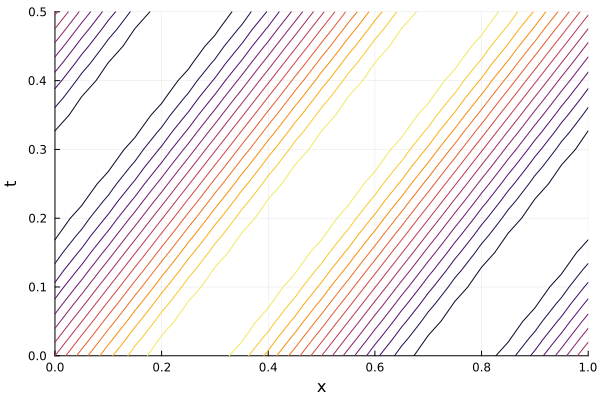

In [24]:
contourU(U_tw_discrete)

#### TW of the continuous travelling wave equation (for comparison)

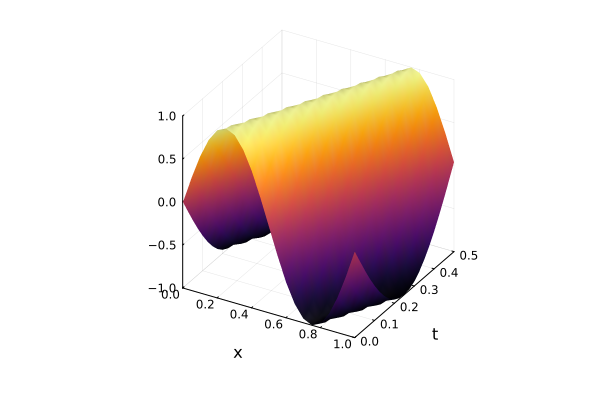

In [25]:
# travelling wave continuous PDE
wave_no = 1
c_tw = sqrt(1+l^2/(4*pi^2*wave_no^2))

amplitude = [1.,0.]
tw(t,x) = amplitude[1]*sin(kappa*(x-c_tw*t))+amplitude[2]*cos(kappa*(x-c_tw*t))

U_tw = tw.(TMesh,transpose(XMesh))
plotU(U_tw)

#### Is the TW of the discrete wave equation a solution of the learned discrete model?

In [26]:
# error
maximum(abs.(DELTest(Learned_Ld,U_tw_discrete)))     # DEL consistency

0.00394094498030495

### Find travelling wave of learned discrete Lagrangian

In [27]:
using Random

In [28]:
# set-up of optimisation problem
f_to_frhatR, frhatR_to_f = translate_fourier_coefficients(M)                                   # helper function
cfrhatR0 = [c_tw_discrete;f_to_frhatR(U_tw_discrete[1,:])];                                    # initial guess from reference
cfrhatR = cfrhatR0 + 0.5*randn(MersenneTwister(1234),Float64,length(f_to_frhatR(zeros(M)))+1)  # perturbed initial guess
loss_hist_d_tw = zeros(2,0);                                                                   # init. loss variable

train_discrete_tw! = find_discrete_travelling_wave(Learned_Ld,cfrhatR,M);

In [29]:
# Run optimisation scheme. Updates variable cfrhatR and loss_hist_d_tw

#train_discrete_tw!(10000; print_every=500, save_every=Inf)

In [30]:
## save TW data
#nowrun = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
#run_dict = Dict("time" => nowrun, "cfrhatR" => cfrhatR, "loss_hist_d_tw" => loss_hist_d_tw)
#open(nowrun*"run_dataTW05pert.json","w") do f
#   JSON.print(f, run_dict)
#end

## load TW data
run_dataTW=JSON.parsefile("2023-02-14_11-21-06run_dataTW05pert.json");
cfrhatR = Float64.(run_dataTW["cfrhatR"])
loss_hist_d_tw = hcat(run_dataTW["loss_hist_d_tw"]...)

2×10000 Matrix{Float64}:
 1.1015     1.0955       1.08953      …  3.75177e-6   3.75132e-6
 3.907e-23  3.88306e-23  3.85923e-23     3.91913e-21  3.92044e-21

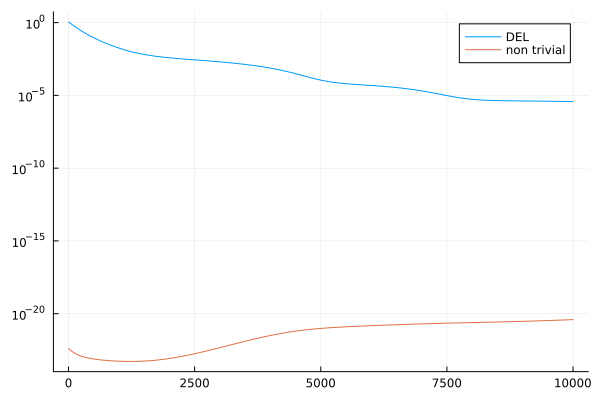

In [31]:
# behaviour TW optimisation scheme
plot(transpose(loss_hist_d_tw),yaxis =:log, labels=["DEL" "non trivial"])

In [32]:
# compute TW profile from Fourier coefficients
c_tw_disc_opt = cfrhatR[1]
frhat_tw_disc = cfrhatR[2:end]
f_tw_disc_opt=frhatR_to_f(frhat_tw_disc);

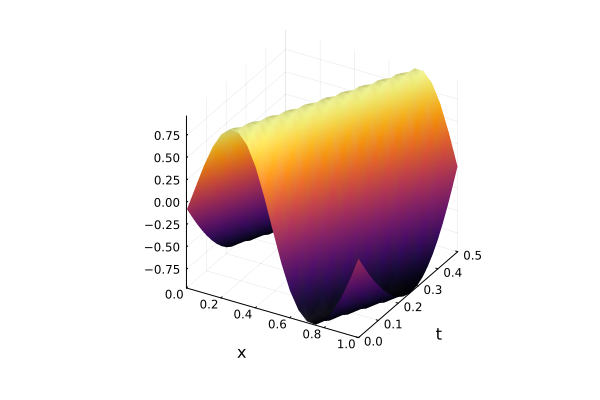

In [33]:
# compute TW on discrete mesh using spectral interpolation
f_tw_disc_opt_fft = fft(f_tw_disc_opt)
u_tw_disc_opt(t,x) = SpectralInterpolation_dft(f_tw_disc_opt_fft,x-c_tw_disc_opt*t,l)
U_tw_disc_opt = real(u_tw_disc_opt.(TMesh,transpose(XMesh)))
plotU(U_tw_disc_opt)

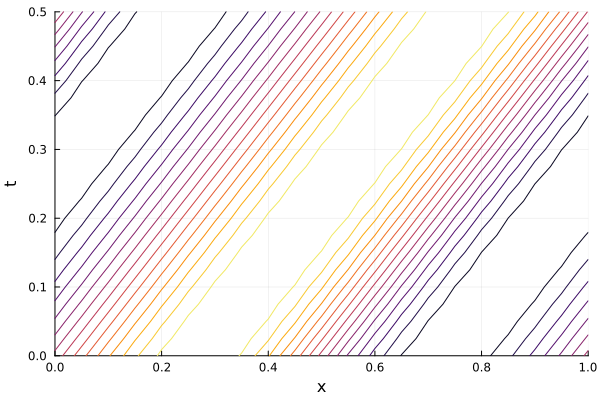

In [34]:
contourU(U_tw_disc_opt)

In [35]:
# wave shape and wave speed error (comparing with reference)
maximum(abs.(U_tw_discrete-U_tw_disc_opt)), abs(c_tw_discrete-c_tw_disc_opt)

(0.11563650899941591, 0.0008419669973607213)

### How well does the scheme continue the solution from the initial data of the identified travelling wave 

In [36]:
U_TW_Continued=PDEContinue(Learned_Ld, U_tw_disc_opt[1,:], U_tw_disc_opt[2,:]; time_steps = N);

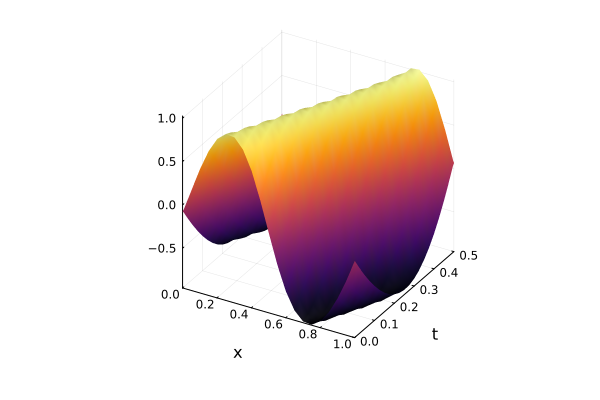

In [37]:
plotU(U_TW_Continued)

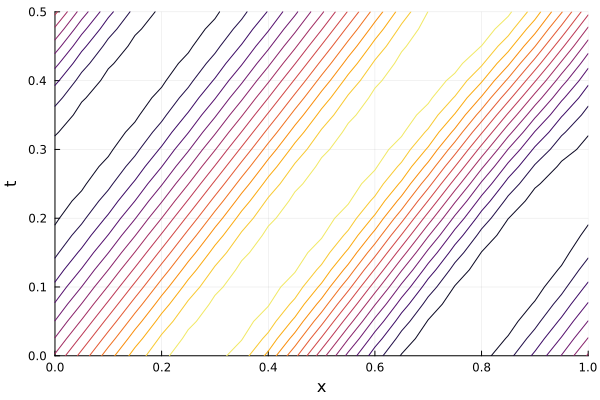

In [38]:
contourU(U_TW_Continued)

In [39]:
# wave shape error (comparing with reference)
maximum(abs.(U_tw_discrete-U_TW_Continued))

0.12059995569664661